### Load the data, extract originals and labels

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import patch
import dataset

In [2]:
start_time = time.time()

originals, labels, count = patch.process_rois('CS8_ROIs.csv', 'cellsuspensionED8/', 0)
print('count = ', count)

print("--- %s seconds ---" % (time.time() - start_time))

count =  883402
--- 7.202937126159668 seconds ---


In [3]:
labels = labels[:count, :]
print('labels shape: ', labels.shape)
originals = originals[: count, :, :]
print('originals shape: ', originals.shape)

labels shape:  (883402, 1)
originals shape:  (883402, 23, 23)


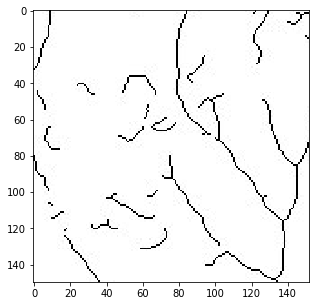

In [4]:
patch.plot_skeleton(labels[252720:275520, 0], 172, 174, 23)

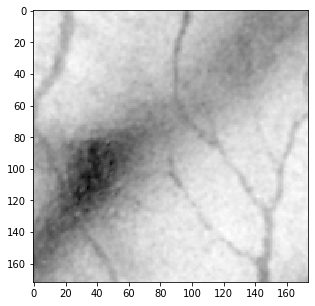

In [5]:
patch.plot_patches(originals[252720:275520, : , :], 172, 174, 23)

### Evaluate the data

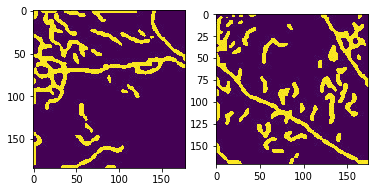

In [6]:
path = '/Users/vladarozova/Dropbox/PhD/angiogenesis/Anna\'s results/cellsuspensionED8/'
filename1 = 'egg2_1_blurred_skeletone.jpg'
filename2 = 'egg3_2_blurred_skeletone.jpg'
img1 = plt.imread(path + filename1)
img2 = plt.imread(path + filename2)
plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)
plt.show()

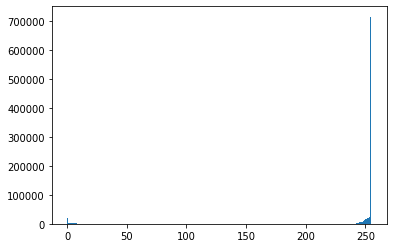

In [7]:
plt.hist(labels, bins = 255)
plt.show()

### Create binary labels

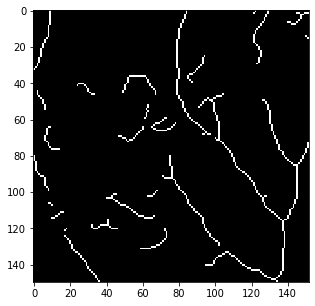

In [8]:
binary_labels = dataset.binarize_labels(labels, 128)
patch.plot_skeleton(binary_labels[252720:275520, 0], 172, 174, 23)

### Samples for test set

In [9]:
dim_1 = [178, 184]
dim_2 = [174, 171]
patch_size = 23
n1 = (dim_1[0] - patch_size + 1) * (dim_1[1] - patch_size + 1)
n2 = (dim_2[0] - patch_size + 1) * (dim_2[1] - patch_size + 1)
print(n1, n2)

25272 22648


In [10]:
X_test = np.zeros((n1 + n2, patch_size, patch_size), dtype = np.float32)
X_test[: n1, :, :] = originals[: n1, :, :]
X_test[-n2 :, :, :] = originals[-n2 :, :, :]

In [11]:
y_test = np.zeros((n1 + n2, 1), dtype = np.float32)
y_test[: n1] = binary_labels[: n1]
y_test[-n2 :] = binary_labels[-n2 :]

In [12]:
originals = originals[n1 : -n2, :, :]
binary_labels = binary_labels[n1 : -n2]
print(originals.shape, binary_labels.shape)

(835482, 23, 23) (835482, 1)


### Choose samples to make the ratio 1:1

In [ ]:
n_pos = int(sum(binary_labels))
n_neg = count - n_pos
print('Number of negative samples: ', n_neg)
print('Number of positive samples: ', n_pos)
print('Fraction of positive samples: ', n_pos / count * 100, '%')
new_ratio = 1
n_neg_new = int(new_ratio * n_pos)
print('Need to randomly choose ', n_neg_new, ' negative samples to make it', new_ratio, ': 1')

In [ ]:
neg_indeces = (np.where(binary_labels == 0))[0]
np.random.shuffle(neg_indeces)
neg_indeces_new = neg_indeces[:n_neg_new]

### Create stratified training and validation sets

In [ ]:
train_ratio = 0.8
n_samples = n_pos + n_neg_new

print(n_samples, n_pos, n_neg_new)
print('train: ', round(train_ratio * n_samples), ', val: ', round((1 - train_ratio) * n_samples))
print('Positive. y_train: ', round(train_ratio * n_pos), ', y_val: ', round((1 - train_ratio) * n_pos))
print('Negative. y_train: ', round(train_ratio * n_neg_new), ', y_val: ', round((1 - train_ratio) * n_neg_new))

In [ ]:
pos_indeces = (np.where(binary_labels == 1))[0]
np.random.shuffle(pos_indeces)
pos_indeces_train = pos_indeces[:round(train_ratio * n_pos)]
pos_indeces_val = pos_indeces[round(train_ratio * n_pos):]

neg_indeces_train = neg_indeces_new[:round(train_ratio * n_neg_new)]
neg_indeces_val = neg_indeces_new[round(train_ratio * n_neg_new):]

In [ ]:
train_indeces = np.append(pos_indeces_train, neg_indeces_train, axis=0)
np.random.shuffle(train_indeces)
X_train = originals[train_indeces, :, :]
y_train = binary_labels[train_indeces]

val_indeces = np.append(pos_indeces_val, neg_indeces_val, axis = 0)
np.random.shuffle(val_indeces)
X_val = originals[val_indeces, :, :]
y_val = binary_labels[val_indeces]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
X_train.dtype

### Calculate stats on training set

In [ ]:
train_mean = np.mean(X_train)
train_sd = np.std(X_train, ddof = 1)

In [ ]:
X_train_std = dataset.standardize(X_train, train_mean, train_sd)

In [ ]:
X_val_std = dataset.standardize(X_val, train_mean, train_sd)

In [ ]:
X_test_std = dataset.standardize(X_test, train_mean, train_sd)

### Create a small dataset

In [ ]:
X_train_small = X_train_std[:100, :, :]
y_train_small = y_train[:100, :]
print(X_train_small.shape, y_train_small.shape)
print(y_train_small.sum())